### This is an example notebook for visualizing some FATES output.  This uses a regional FATES run over part of California to show some of the more complex dimensioned dat athe FATES uses.

### load libraries, etc.  

In [1]:
import numpy as np
#
import xarray as xr
import matplotlib.pyplot as plt
#
## this next library contains some helper functions for reshaping FATES variables into easier to work with dimensions
import ctsm_py.fates_xarray_funcs as fa       
#
import cartopy.crs as ccrs



 ### Load the fates history file.

In [2]:
fates_history_filename = 'fates_calif_test_data.nc'

fates_history_fin = xr.open_dataset(fates_history_filename)

### use the last 20 years
nyears = int(len(fates_history_fin.variables['time'])/12)
tave_start = (nyears-20)*12
tave_stop  = nyears*12

nscls_bins = len(fates_history_fin.variables['fates_levscls'])
npfts = len(fates_history_fin.variables['fates_levpft'])
nage_bins = len(fates_history_fin.variables['fates_levage'])

min_lat_plotting = 32.
max_lat_plotting = 44.
min_lon_plotting = 235.
max_lon_plotting = 242.5

geog_range_plotting = [min_lon_plotting, max_lon_plotting, min_lat_plotting, max_lat_plotting]

### make a really simple map

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


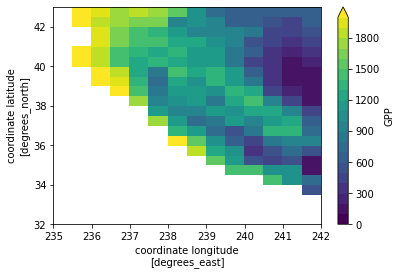

In [3]:
fates_gpp_tmean = fates_history_fin.GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400. * 365.
fates_gpp_tmean.plot(levels=np.arange(0.,2100,100))

### make the same really simple map, on a map projection

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


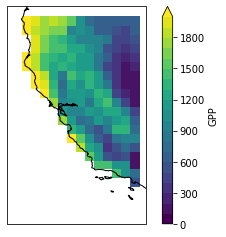

In [4]:
ax = plt.subplot(projection=ccrs.PlateCarree())

fates_gpp_tmean = fates_history_fin.GPP.isel(time=slice(tave_start,tave_stop)).mean(dim='time') * 86400. * 365.
fates_gpp_tmean.plot(levels=np.arange(0.,2100,100), transform=ccrs.PlateCarree())
ax.coastlines()

### make a zonal-mean plot

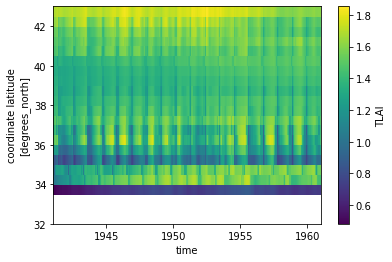

In [5]:
fates_lai_zonalmean = fates_history_fin.TLAI.isel(time=slice(tave_start,tave_stop)).mean(dim='lon')
fates_lai_zonalmean.plot(x='time', y='lat')

In [6]:
### plot fates patch age distribution, not on map projection

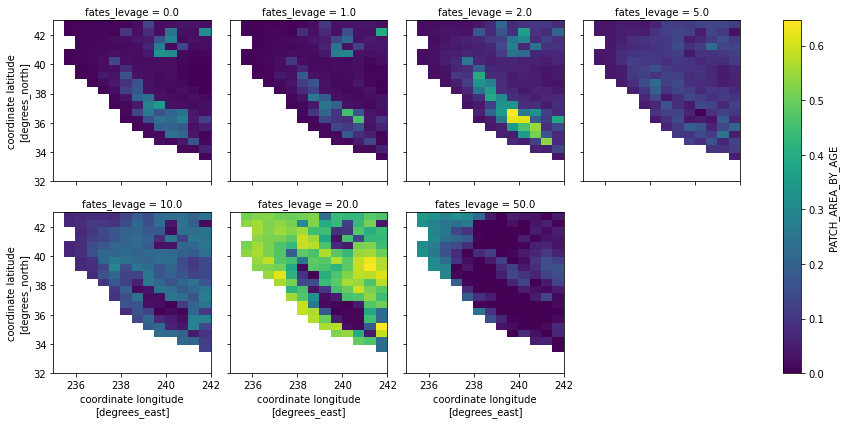

In [7]:
patch_area_by_age_tmean = fates_history_fin.PATCH_AREA_BY_AGE.isel(time=slice(tave_start,tave_stop)).mean(dim='time')
patch_area_by_age_tmean.plot(x='lon',y='lat',col='fates_levage', col_wrap=4)

### plot fates patch age distribution, using map projection

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


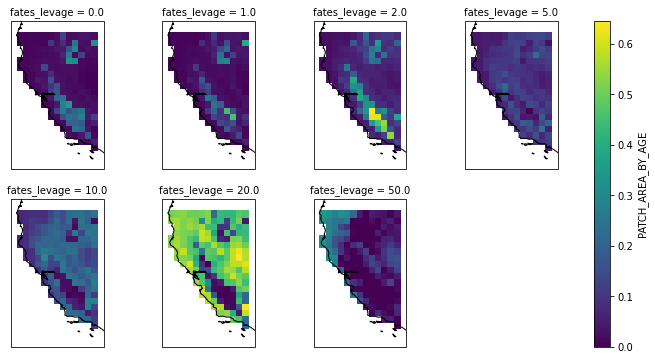

In [8]:
patch_area_by_age_tmean = fates_history_fin.PATCH_AREA_BY_AGE.isel(time=slice(tave_start,tave_stop)).mean(dim='time')

fg = patch_area_by_age_tmean.plot(x='lon',y='lat',col='fates_levage', col_wrap=4, transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.PlateCarree()))

# have to tell xarray the geographic range to plot or else it zooms out too much (see https://github.com/pydata/xarray/issues/619)
for ax in fg.axes.flat:
    ax.set_extent(geog_range_plotting, crs=ccrs.PlateCarree())
    ax.coastlines()

### plot fates canopy cover by patch age distribution, in map projection

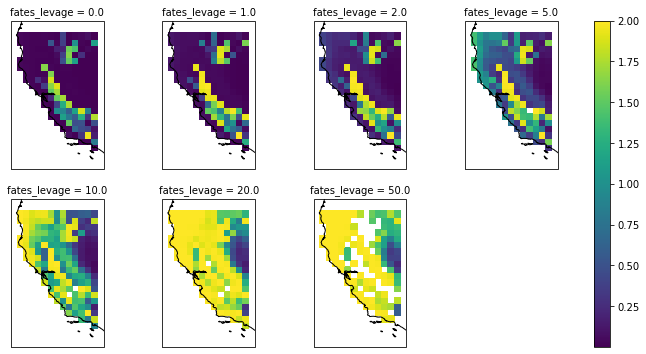

In [9]:
canopy_cover_by_patch_age_tmean = fates_history_fin.CANOPY_AREA_BY_AGE.isel(time=slice(tave_start,tave_stop)).mean(dim='time') / fates_history_fin.PATCH_AREA_BY_AGE.isel(time=slice(tave_start,tave_stop)).mean(dim='time')

fg = canopy_cover_by_patch_age_tmean.plot(x='lon',y='lat',col='fates_levage', col_wrap=4, transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.PlateCarree()))

for ax in fg.axes.flat:
    ax.set_extent(geog_range_plotting, crs=ccrs.PlateCarree())
    ax.coastlines()

### plot PFT-resolved crown area coverage

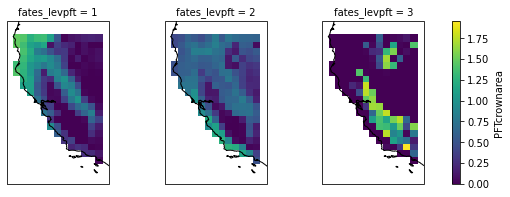

In [10]:
fates_pftcrownarea_tmean = fates_history_fin.PFTcrownarea.isel(time=slice(tave_start,tave_stop)).mean(dim='time')/1e4

fg = fates_pftcrownarea_tmean.plot(x='lon', y='lat', col='fates_levpft', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.PlateCarree()))

for ax in fg.axes.flat:
    ax.set_extent(geog_range_plotting, crs=ccrs.PlateCarree())
    ax.coastlines()

### plot some mortality and disturbance diagnostics from FATES

#### let's assume we've output these rates using the size-class by PFT resolved mortality rates

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


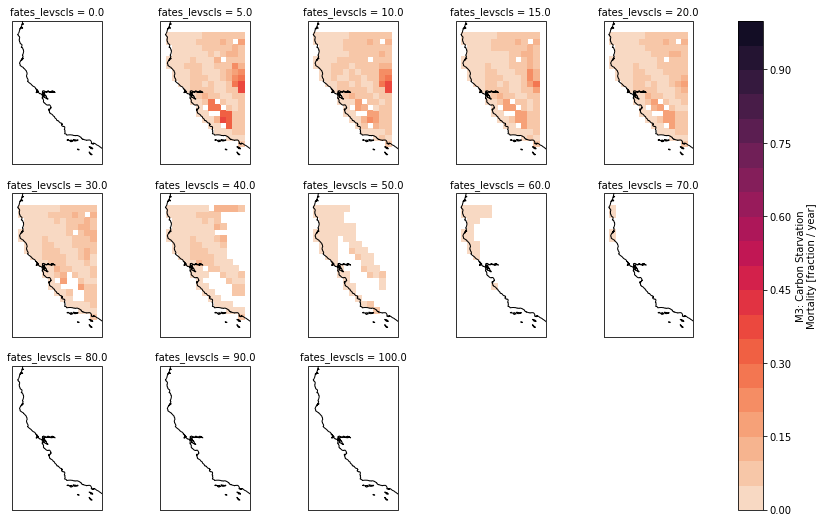

In [11]:
NPLANT_SCPF_unrolled = fa.scpf_to_scls_by_pft(fates_history_fin.NPLANT_SCPF, fates_history_fin)

## "M3" is the carbon starvation mortality
M3_SCPF_unrolled = fa.scpf_to_scls_by_pft(fates_history_fin.M3_SCPF, fates_history_fin)

cstarvemortrate = M3_SCPF_unrolled.isel(time=slice(tave_start,tave_stop)).mean(dim='time')/NPLANT_SCPF_unrolled.isel(time=slice(tave_start,tave_stop)).mean(dim='time')

cstarvemortrate.attrs['long_name'] = 'M3: Carbon Starvation Mortality'
cstarvemortrate.attrs['units'] = 'fraction / year'

fg = cstarvemortrate.isel(fates_levpft=0).plot(x='lon', y='lat', col='fates_levscls', col_wrap=5, levels=np.arange(21)/20., cmap='rocket_r', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.PlateCarree()))

for ax in fg.axes.flat:
    ax.set_extent(geog_range_plotting, crs=ccrs.PlateCarree())
    ax.coastlines()

### plot the plant number density over time (from bare ground intiialization)

### plot the number density of all PFTs together

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


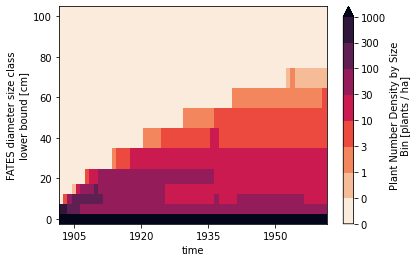

In [12]:
### plot number density by size class over time
NPLANT_SCLS_geogmean = fa.monthly_to_annual(fates_history_fin.NPLANT_SCLS.mean(dim='lat').mean(dim='lon'))
NPLANT_SCLS_geogmean.attrs['long_name'] = 'Plant Number Density by Size Bin'
NPLANT_SCLS_geogmean.attrs['units'] = 'plants / ha'
NPLANT_SCLS_geogmean.plot(x='time', y='fates_levscls', levels=[0.,0.3, 1,3, 10,30,100,300,1000.], cmap='rocket_r')

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0, 0.5, 'Plant Number Density (n ha$^{-1}$ cm$^{-1}$)')

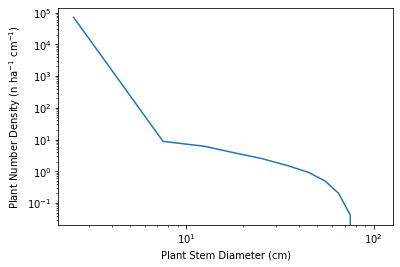

In [13]:
### plot the time-averaged number density, normalized by size class bin width

### first make a virtual max size upper edge that is bigger than the largest minimum bin, and calculate the bin widths
biggest_size = fates_history_fin.fates_levscls[nscls_bins-1] * (fates_history_fin.fates_levscls[nscls_bins-1]/fates_history_fin.fates_levscls[nscls_bins-2])
levscls_ext = np.append(fates_history_fin.fates_levscls,biggest_size)
dlevscls = xr.DataArray(levscls_ext[1:] - levscls_ext[0:nscls_bins], dims={'fates_levscls':fates_history_fin.fates_levscls})
levscls_mid = fates_history_fin.fates_levscls + dlevscls/2.

NPLANT_SCLS_timeave_percm_geogmean = fates_history_fin.NPLANT_SCLS.mean(dim='lat').mean(dim='lon').isel(time=slice(tave_start,tave_stop)).mean(dim='time') / dlevscls
plt.loglog(levscls_mid,NPLANT_SCLS_timeave_percm_geogmean)
plt.xlabel('Plant Stem Diameter (cm)')
plt.ylabel('Plant Number Density (n ha$^{-1}$ cm$^{-1}$)')

###  plot the number density of trees, separated by PFTs

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


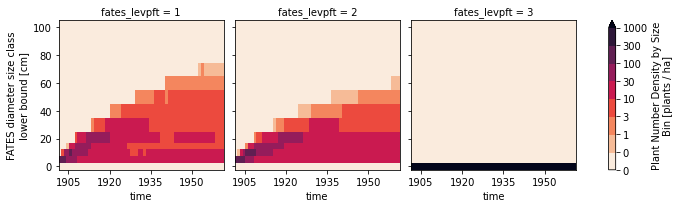

In [14]:
### plot number density by size class over time, now separated by PFTs

NPLANT_SCPF_unrolled_geogmean = fa.monthly_to_annual(NPLANT_SCPF_unrolled.mean(dim='lat').mean(dim='lon'))
NPLANT_SCPF_unrolled_geogmean.attrs['long_name'] = 'Plant Number Density by Size Bin'
NPLANT_SCPF_unrolled_geogmean.attrs['units'] = 'plants / ha'
NPLANT_SCPF_unrolled_geogmean.plot(x='time', y='fates_levscls', col='fates_levpft', levels=[0.,0.3, 1,3, 10,30,100,300,1000.], cmap='rocket_r')

In [15]:
### plot the carbon starvation rate over time (from bare ground intiialization)

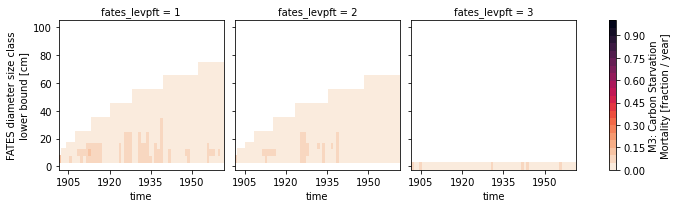

In [16]:
cstarvemortrate_geogmean = fa.monthly_to_annual(M3_SCPF_unrolled.mean(dim='lat').mean(dim='lon'))/fa.monthly_to_annual(NPLANT_SCPF_unrolled.mean(dim='lat').mean(dim='lon'))
cstarvemortrate_geogmean.attrs['long_name'] = 'M3: Carbon Starvation Mortality'
cstarvemortrate_geogmean.attrs['units'] = 'fraction / year'

cstarvemortrate_geogmean.plot(x='time', y='fates_levscls', col='fates_levpft', levels=np.arange(21)/20., cmap='rocket_r')

### Plot the amount of fuel by fuel size class

/glade/work/charlie/my_npl_clone2/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


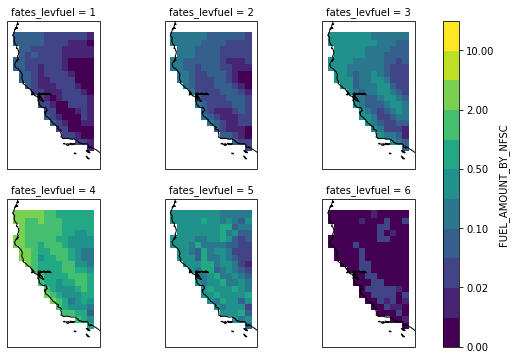

In [17]:
FUEL_AMOUNT_BY_NFSC = fates_history_fin.FUEL_AMOUNT_BY_NFSC.isel(time=slice(tave_start,tave_stop)).mean(dim='time') 
fg = FUEL_AMOUNT_BY_NFSC.plot(x='lon', y='lat', col='fates_levfuel', levels=[0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1., 2., 5., 10., 20.], col_wrap=3, transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.PlateCarree()))

for ax in fg.axes.flat:
    ax.set_extent(geog_range_plotting, crs=ccrs.PlateCarree())
    ax.coastlines()

### plot the number of plants by the patch age upon which they sit

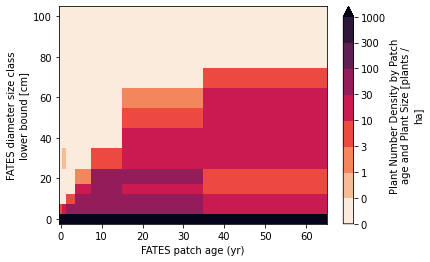

In [18]:
NPLANT_SCAG_unrolled = fa.scag_to_scls_by_age(fates_history_fin.NPLANT_SCAG, fates_history_fin)
NPLANT_by_size_and_age = NPLANT_SCAG_unrolled.mean(dim='lat').mean(dim='lon').isel(time=slice(tave_start,tave_stop)).mean(dim='time') / fates_history_fin.PATCH_AREA_BY_AGE.mean(dim='lat').mean(dim='lon').isel(time=slice(tave_start,tave_stop)).mean(dim='time')
NPLANT_by_size_and_age.attrs['long_name'] = 'Plant Number Density by Patch age and Plant Size'
NPLANT_by_size_and_age.attrs['units'] = 'plants / ha'
NPLANT_by_size_and_age.plot(x='fates_levage', y='fates_levscls', levels=[0.,0.3, 1,3, 10,30,100,300,1000.], cmap='rocket_r')